<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><em>Описание данных</em></a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Переименование-столбцов" data-toc-modified-id="Переименование-столбцов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><em>Переименование столбцов</em></a></span></li><li><span><a href="#Обработка-дубликатов" data-toc-modified-id="Обработка-дубликатов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><em>Обработка дубликатов</em></a></span></li><li><span><a href="#Изменение-типов-данных" data-toc-modified-id="Изменение-типов-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><em>Изменение типов данных</em></a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span><em>Обработка пропусков</em></a></span></li><li><span><a href="#Подбор-необходимых-признаков-и-борьба-с-мультиколлинеарностью" data-toc-modified-id="Подбор-необходимых-признаков-и-борьба-с-мультиколлинеарностью-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span><em>Подбор необходимых признаков и борьба с мультиколлинеарностью</em></a></span></li><li><span><a href="#Обработка-аномальных-значений" data-toc-modified-id="Обработка-аномальных-значений-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span><em>Обработка аномальных значений</em></a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span><em>Проверка модели на адекватность</em></a></span></li></ul></li><li><span><a href="#Общий-вывод-по-исследованию" data-toc-modified-id="Общий-вывод-по-исследованию-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод по исследованию</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

---
### *Описание данных*

__*Для исследования получены csv-файлы:*__

Технологический процесс:
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов:
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats
from scipy.stats import ks_2samp
from sklearn.impute import KNNImputer
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, KFold, cross_val_score)
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

In [2]:
try:
    df_train = pd.read_csv('datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
    df_test = pd.read_csv('datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
    df = pd.read_csv('datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)
except FileNotFoundError:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date',
                           parse_dates=True)
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date',
                          parse_dates=True)
    df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date',
                     parse_dates=True)

In [3]:
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
df.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Проверим правильность расчета эффективности обогащения золотосодержащей породы на примере рассчитанного коэффициента после процесса флотации на тренировочной выборке.

In [6]:
# C — доля золота в концентрате после флотации/очистки;
C = df_train['rougher.output.concentrate_au']
# F — доля золота в сырье/концентрате до флотации/очистки;
F = df_train['rougher.input.feed_au']
# T — доля золота в отвальных хвостах после флотации/очистки.
T = df_train['rougher.output.tail_au']

# По формуле расчета коэффициента обогащения
check_array = (C * (F - T)) / (F * (C - T)) * 100
mean_absolute_error(check_array, df_train['rougher.output.recovery'])

9.73512347450521e-15

На основе полученного значения абсолютного отклонения значений мы делаем вывод, что данный коэффициент рассчитан верно.

На этапе первичного анализа данных было обнаружено, что количество столбцов в тестовом df (52) не соответствует количеству столбцов в тренировочном и полном df (86). Выясним, какие столбцы отсутствуют.

In [7]:
np.array(df_train.columns.difference(df_test.columns))

array(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag',
       'final.output.tail_au', 'final.output.tail_pb',
       'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые есть в обучающей. Также в тестовом наборе нет целевых признаков. Нам стоит добавить к тестовой выборке два целевых параметра.

---
### *Переименование столбцов*

In [8]:
df.columns = df.columns.str.replace('.', '_', regex=False)
df_train.columns = df_train.columns.str.replace('.', '_', regex=False)
df_test.columns = df_test.columns.str.replace('.', '_', regex=False)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final_output_concentrate_ag                         14148 non-null  float64
 1   final_output_concentrate_pb                         14148 non-null  float64
 2   final_output_concentrate_sol                        13938 non-null  float64
 3   final_output_concentrate_au                         14149 non-null  float64
 4   final_output_recovery                               14149 non-null  float64
 5   final_output_tail_ag                                14149 non-null  float64
 6   final_output_tail_pb                                14049 non-null  float64
 7   final_output_tail_sol                               14144 non-null  float64
 8   final_output_tail_au                     

Обнаружены пропущенные значения. Многим столбцам необходимо произвести изменение разрядности типа данных, с целью незначительной экономии памяти.

---
### *Обработка дубликатов*

In [10]:
df.duplicated().sum()

0

Полных дубликатов среди всех строк не обнаружено.

---
### *Изменение типов данных*

In [11]:
fcols = df.select_dtypes('float').columns
f_test_cols = df_test.select_dtypes('float').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df_test[f_test_cols] = df_test[f_test_cols].apply(pd.to_numeric, downcast='float')
df_train[fcols] = df_train[fcols].apply(pd.to_numeric, downcast='float')

Типы данных успешно преобразованы.

---
### *Обработка пропусков*

In [12]:
pd.DataFrame(round(df_train.isna().mean() * 100)) \
    .rename(columns={0: 'space'}).query('space > 0') \
    .sort_values(by='space', ascending=True) \
    .style.background_gradient('coolwarm')

,space
final_output_concentrate_sol,1.000000
final_output_tail_pb,1.000000
primary_cleaner_input_xanthate,1.000000
primary_cleaner_output_concentrate_pb,1.000000
rougher_input_feed_pb,1.000000
rougher_input_feed_size,1.000000
rougher_input_feed_sol,1.000000
primary_cleaner_output_concentrate_sol,2.000000
secondary_cleaner_state_floatbank2_a_air,2.000000
rougher_input_floatbank11_xanthate,3.000000


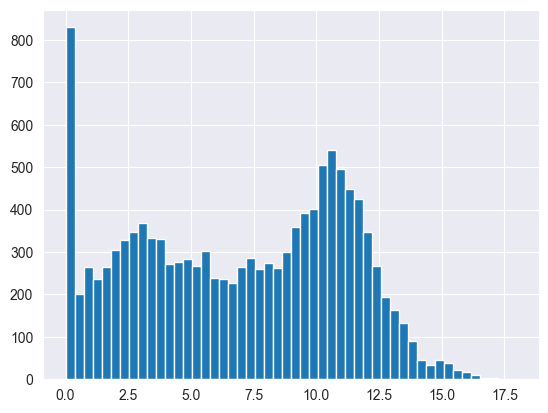

In [13]:
df_train.secondary_cleaner_output_tail_sol.hist(bins=50);

In [14]:
# def KNN_recovery(data):
#     imputer = KNNImputer(n_neighbors=10)
#     imputed_data = imputer.fit_transform(data)
#     data = pd.DataFrame(imputed_data, columns=data.columns)
#     return data

In [15]:
df_train = df_train.ffill(axis=0)
df_train = df_train.bfill(axis=0)

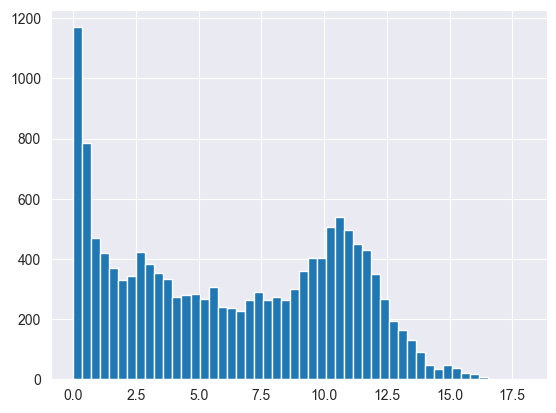

In [16]:
df_train.secondary_cleaner_output_tail_sol.hist(bins=50);

Сравнив чистоту восстановления пропусков между двумя методами - KNN и ffill, предпочтение было отдано в пользу второго, так как в значительно меньшей степени вносит искажение в изначальное распределение.

In [17]:
df_test = df_test.ffill(axis=0)
df_test = df_test.bfill(axis=0)

Также стоит обработать значения с нулевыми значениями, исключив их, так как в заданных признаках передается относительная концентрация вещества, которая не может ровняться 0.

In [18]:
df_train = df_train.query('~(' + ' | '.join([f"{col} == 0" for col in df_train.columns]) + ')')

---
### *Подбор необходимых признаков и борьба с мультиколлинеарностью*

Найдем силу корреляции независимых признаков с одним из целевых признаков.

In [19]:
corr_dict = {}
for col in list(df_train.columns.intersection(df_test.columns)):
    corr_dict[col] = abs(df_train[col].corr(df_train['rougher_output_concentrate_au']))
corr_dict = dict(sorted(corr_dict.items(), key=lambda x: x[1]))
corr_dict

{'rougher_state_floatbank10_c_air': 0.01096251310186831,
 'secondary_cleaner_state_floatbank3_b_level': 0.042858494251537586,
 'primary_cleaner_input_sulfate': 0.05131952140805216,
 'rougher_state_floatbank10_d_air': 0.05537965923962667,
 'primary_cleaner_input_xanthate': 0.05608603251403435,
 'rougher_state_floatbank10_b_level': 0.061947176465940494,
 'secondary_cleaner_state_floatbank2_a_level': 0.06499827163304439,
 'secondary_cleaner_state_floatbank2_b_level': 0.0691251423930559,
 'rougher_state_floatbank10_c_level': 0.07088945205978008,
 'rougher_state_floatbank10_b_air': 0.072913982619576,
 'primary_cleaner_input_depressant': 0.07630864518259099,
 'rougher_state_floatbank10_e_level': 0.07680989719631633,
 'rougher_state_floatbank10_d_level': 0.07791443026461252,
 'rougher_state_floatbank10_f_level': 0.08358727086219332,
 'secondary_cleaner_state_floatbank3_a_level': 0.08424037397460114,
 'primary_cleaner_input_feed_size': 0.08689618260013551,
 'secondary_cleaner_state_floatbank3_

Найдем пары независимых признаков, величина корреляции между которыми выше значения 0.9. И выберем из них те признаки, которые сильнее влияют на целевой признак.

In [20]:
corr_matrix = df_train[list(df_train.columns.intersection(df_test.columns))].corr()
high_corr_idx = np.where(np.abs(corr_matrix) > 0.9)
high_corr_features = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_idx) if
                      x != y and x < y]
high_corr_features_list = []
[high_corr_features_list.extend(pair) for pair in high_corr_features]

best_signs = []
for col in high_corr_features:
    if corr_dict[col[0]] > corr_dict[col[1]]:
        best_signs.append(col[0])
    else:
        best_signs.append(col[1])
best_signs

['primary_cleaner_state_floatbank8_a_air',
 'primary_cleaner_state_floatbank8_c_air',
 'primary_cleaner_state_floatbank8_a_level',
 'primary_cleaner_state_floatbank8_a_level',
 'primary_cleaner_state_floatbank8_c_air',
 'primary_cleaner_state_floatbank8_b_level',
 'rougher_input_floatbank10_xanthate',
 'rougher_state_floatbank10_b_air',
 'rougher_state_floatbank10_b_air',
 'rougher_state_floatbank10_c_level',
 'rougher_state_floatbank10_d_level',
 'rougher_state_floatbank10_e_level',
 'rougher_state_floatbank10_f_level',
 'rougher_state_floatbank10_d_air',
 'rougher_state_floatbank10_d_level',
 'rougher_state_floatbank10_e_level',
 'rougher_state_floatbank10_f_level',
 'rougher_state_floatbank10_d_level',
 'rougher_state_floatbank10_f_level',
 'rougher_state_floatbank10_f_air',
 'rougher_state_floatbank10_f_level']

In [21]:
col_best_sign = set(df_train[df_test.columns]).difference(high_corr_features_list).union(best_signs)
df_train[col_best_sign].head()

,secondary_cleaner_state_floatbank3_b_level,rougher_state_floatbank10_d_air,primary_cleaner_state_floatbank8_a_air,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank2_a_air,rougher_input_feed_pb,secondary_cleaner_state_floatbank2_b_air,secondary_cleaner_state_floatbank3_b_air,rougher_input_floatbank10_xanthate,secondary_cleaner_state_floatbank5_a_air,...,rougher_state_floatbank10_e_level,rougher_input_floatbank11_sulfate,rougher_state_floatbank10_d_level,rougher_state_floatbank10_a_level,secondary_cleaner_state_floatbank5_b_level,rougher_input_feed_sol,secondary_cleaner_state_floatbank4_a_air,primary_cleaner_state_floatbank8_c_air,primary_cleaner_input_feed_size,rougher_state_floatbank10_c_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-499.340973,1598.937256,1549.775757,14.151341,25.853109,2.284912,23.893660,21.940409,6.007990,9.925633,...,-455.462982,11.836743,-451.294128,-404.066986,-500.470978,36.808594,14.016835,1549.873901,7.25,-442.204468
2016-01-15 01:00:00,-499.446899,1600.527588,1576.166626,13.998353,25.880539,2.266033,23.889530,22.085714,6.005766,10.039246,...,-450.869843,11.996162,-449.953644,-400.065186,-500.582153,35.753384,13.992281,1575.994141,7.25,-449.830658
2016-01-15 02:00:00,-499.901978,1599.849365,1601.556152,14.028663,26.005245,2.159622,23.886656,23.957716,6.197377,10.070913,...,-449.937592,11.920305,-449.954193,-400.074036,-500.517578,35.971630,14.015016,1602.003540,7.25,-449.954498
2016-01-15 03:00:00,-499.944702,1597.725220,1599.968750,14.005551,25.942507,2.037807,23.955517,23.954443,6.203177,9.970366,...,-450.030151,11.692450,-450.130127,-400.200165,-500.255920,36.862240,14.036510,1600.304199,7.25,-449.910492
2016-01-15 04:00:00,-499.990295,1599.759033,1601.339722,13.996647,26.024788,1.786875,23.955345,23.958944,6.198826,9.925709,...,-448.877197,10.960521,-449.909790,-399.752716,-500.356049,34.347664,14.027298,1599.581909,7.25,-450.034363


Итого мы получили 46 независимых признаков с отсутствующей мультиколлинеарностью.

---
### *Обработка аномальных значений*

In [22]:
df_train[col_best_sign].describe(percentiles=[0.0012, 0.01, .5, .99, .9988]).drop(['count', 'mean', 'std'], axis=0)

,secondary_cleaner_state_floatbank3_b_level,rougher_state_floatbank10_d_air,primary_cleaner_state_floatbank8_a_air,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank2_a_air,rougher_input_feed_pb,secondary_cleaner_state_floatbank2_b_air,secondary_cleaner_state_floatbank3_b_air,rougher_input_floatbank10_xanthate,secondary_cleaner_state_floatbank5_a_air,...,rougher_state_floatbank10_e_level,rougher_input_floatbank11_sulfate,rougher_state_floatbank10_d_level,rougher_state_floatbank10_a_level,secondary_cleaner_state_floatbank5_b_level,rougher_input_feed_sol,secondary_cleaner_state_floatbank4_a_air,primary_cleaner_state_floatbank8_c_air,primary_cleaner_input_feed_size,rougher_state_floatbank10_c_level
min,-759.177368,-0.124766,0.016993,0.195324,0.077503,0.088552,0.045108,6.137256e-22,0.001428,-0.372054,...,-649.443909,0.000098,-640.518982,-650.086243,-800.006165,0.463867,0.000073,0.040552,1.08,-610.357544
0.1%,-755.828017,787.593585,1099.697684,0.306864,19.900437,0.125889,14.864434,9.933728e+00,0.006311,-0.370389,...,-577.465804,0.003562,-551.704102,-600.297080,-604.596915,9.733476,5.157853,1101.374094,4.97,-551.863540
1%,-529.587549,796.992365,1199.287598,10.969041,22.021690,1.019183,14.930666,1.000801e+01,3.218325,7.922855,...,-512.932587,0.223354,-508.200043,-501.263406,-599.637097,19.403785,9.944090,1199.277905,5.90,-503.852740
50%,-499.962738,1200.586670,1601.516235,19.980219,30.052143,3.377577,27.079950,2.201884e+01,5.998374,17.054222,...,-499.630981,11.569222,-499.497375,-300.197357,-499.925537,37.087582,19.988781,1601.225708,7.30,-499.695953
99%,-389.902908,1660.335486,1802.711890,30.021002,37.318789,6.126519,32.996078,3.500980e+01,7.995190,29.983859,...,-348.935110,19.999759,-348.507272,-299.290289,-399.329337,45.039396,30.035769,1802.579443,8.75,-349.112698
99.9%,-279.811053,1779.516170,1812.370519,31.985153,41.248308,6.598665,35.035926,3.504030e+01,9.003246,32.731324,...,-299.590248,30.007941,-299.481468,-296.136107,-306.560710,46.930127,30.063974,1835.686965,9.40,-299.472856
max,-159.742325,1817.199341,2079.531250,32.188904,52.651398,7.142594,35.152122,3.507284e+01,9.703448,43.709930,...,-272.199585,37.980648,-282.986206,-281.039307,-181.732666,48.363178,30.115736,2013.156494,10.47,-295.103394


In [23]:
def check_features(data, columns):
    list_0012, list_01, list_99, list_9988 = [], [], [], []
    for col in columns:
        min_val = data[col].min()
        quantile_0012 = data[col].quantile(0.0012)
        quantile_01 = data[col].quantile(0.01)
        max_val = data[col].max()
        quantile_9988 = data[col].quantile(0.9988)
        quantile_99 = data[col].quantile(0.99)
        if abs(quantile_0012) < abs(quantile_01) / 3:
            list_01.append(col)
        elif abs(min_val) < abs(quantile_0012) / 3:
            list_0012.append(col)

        if abs(quantile_99) < abs(quantile_9988) / 3:
            list_99.append(col)
        elif abs(max_val) / 3 > abs(quantile_9988):
            list_9988.append(col)
    return list_0012, list_01, list_99, list_9988

Проанализировав присутствующие аномальные значения в некоторых признаках произведем поэтапную очистку по квантилям.

In [24]:
def correct_features(data, columns):
    list_0012, list_01, list_99, list_9988 = check_features(data, columns)

    for col in list_0012:
        q = data[col].quantile(0.0012)
        data = data.loc[data[col] >= q, columns]

    for col in list_01:
        q = data[col].quantile(0.01)
        data = data.loc[data[col] >= q, columns]

    for col in list_99:
        q = data[col].quantile(0.99)
        data = data.loc[data[col] <= q, columns]

    for col in list_9988:
        q = data[col].quantile(0.9988)
        data = data.loc[data[col] <= q, columns]

    return data

In [25]:
df_train = correct_features(df_train, col_best_sign)

In [26]:
df_train

,secondary_cleaner_state_floatbank3_b_level,rougher_state_floatbank10_d_air,primary_cleaner_state_floatbank8_a_air,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank2_a_air,rougher_input_feed_pb,secondary_cleaner_state_floatbank2_b_air,secondary_cleaner_state_floatbank3_b_air,rougher_input_floatbank10_xanthate,secondary_cleaner_state_floatbank5_a_air,...,rougher_state_floatbank10_e_level,rougher_input_floatbank11_sulfate,rougher_state_floatbank10_d_level,rougher_state_floatbank10_a_level,secondary_cleaner_state_floatbank5_b_level,rougher_input_feed_sol,secondary_cleaner_state_floatbank4_a_air,primary_cleaner_state_floatbank8_c_air,primary_cleaner_input_feed_size,rougher_state_floatbank10_c_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-499.340973,1598.937256,1549.775757,14.151341,25.853109,2.284912,23.893660,21.940409,6.007990,9.925633,...,-455.462982,11.836743,-451.294128,-404.066986,-500.470978,36.808594,14.016835,1549.873901,7.250000,-442.204468
2016-01-15 01:00:00,-499.446899,1600.527588,1576.166626,13.998353,25.880539,2.266033,23.889530,22.085714,6.005766,10.039246,...,-450.869843,11.996162,-449.953644,-400.065186,-500.582153,35.753384,13.992281,1575.994141,7.250000,-449.830658
2016-01-15 02:00:00,-499.901978,1599.849365,1601.556152,14.028663,26.005245,2.159622,23.886656,23.957716,6.197377,10.070913,...,-449.937592,11.920305,-449.954193,-400.074036,-500.517578,35.971630,14.015016,1602.003540,7.250000,-449.954498
2016-01-15 03:00:00,-499.944702,1597.725220,1599.968750,14.005551,25.942507,2.037807,23.955517,23.954443,6.203177,9.970366,...,-450.030151,11.692450,-450.130127,-400.200165,-500.255920,36.862240,14.036510,1600.304199,7.250000,-449.910492
2016-01-15 04:00:00,-499.990295,1599.759033,1601.339722,13.996647,26.024788,1.786875,23.955345,23.958944,6.198826,9.925709,...,-448.877197,10.960521,-449.909790,-399.752716,-500.356049,34.347664,14.027298,1599.581909,7.250000,-450.034363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-17 17:59:59,-499.981415,955.171570,1652.660889,20.010332,35.038258,4.768125,30.066959,22.988928,8.955597,17.980463,...,-499.779541,6.929364,-500.294983,-299.778381,-500.009949,36.808872,23.032806,1651.924805,6.660000,-499.695068
2018-08-17 18:59:59,-500.043945,953.510010,1649.672729,19.978991,34.991783,4.358654,30.027288,22.998003,8.994282,17.995857,...,-499.868073,6.426564,-499.809845,-300.022766,-500.102020,34.969574,22.983028,1652.590332,6.466667,-499.723724
2018-08-17 23:59:59,-500.027344,950.756775,1649.979858,20.004410,34.937996,4.907868,29.941616,22.948807,8.991273,17.990313,...,-499.980774,7.115128,-499.706299,-300.103088,-499.724609,37.571167,23.011484,1649.557373,6.239999,-499.675903


In [27]:
df_train.describe(percentiles=[0.0012, 0.01, .5, .99, .9988]).drop(['count', 'mean', 'std'], axis=0)

,secondary_cleaner_state_floatbank3_b_level,rougher_state_floatbank10_d_air,primary_cleaner_state_floatbank8_a_air,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank2_a_air,rougher_input_feed_pb,secondary_cleaner_state_floatbank2_b_air,secondary_cleaner_state_floatbank3_b_air,rougher_input_floatbank10_xanthate,secondary_cleaner_state_floatbank5_a_air,...,rougher_state_floatbank10_e_level,rougher_input_floatbank11_sulfate,rougher_state_floatbank10_d_level,rougher_state_floatbank10_a_level,secondary_cleaner_state_floatbank5_b_level,rougher_input_feed_sol,secondary_cleaner_state_floatbank4_a_air,primary_cleaner_state_floatbank8_c_air,primary_cleaner_input_feed_size,rougher_state_floatbank10_c_level
min,-757.801758,787.966919,1099.774658,10.969148,19.909031,1.040558,14.872181,9.938304,3.500625,7.924336,...,-649.443909,6.290900,-640.518982,-650.086243,-800.006165,12.952582,7.427736,1101.711426,4.970000,-553.310913
0.1%,-755.743763,792.390093,1196.975064,10.972698,19.984625,1.126320,14.892344,9.951453,3.597153,7.932996,...,-551.625873,6.325125,-550.676737,-600.202013,-602.373511,16.293267,8.951233,1195.223932,5.540000,-551.250554
1%,-526.863049,797.703943,1199.662817,10.983124,23.944746,1.459919,14.935706,10.048211,3.998562,7.972279,...,-505.265582,6.695947,-506.075720,-500.935034,-599.777783,22.577235,9.957677,1199.975537,6.060000,-503.251575
50%,-499.960236,1200.804077,1601.567505,19.982298,30.049356,3.416779,27.071072,22.018642,6.000182,17.288982,...,-499.624634,11.982956,-499.495728,-300.198517,-499.922119,37.239914,19.987806,1601.281738,7.300000,-499.694611
99%,-390.539886,1661.739917,1802.739136,30.021217,37.283875,6.145282,32.979195,35.010464,7.996667,29.993917,...,-349.498981,19.999645,-349.294818,-299.321240,-399.343903,45.154177,30.034332,1802.650244,8.743999,-349.578400
99.9%,-288.008267,1777.079665,1815.719222,31.991630,41.079747,6.617389,35.010140,35.040531,9.005452,32.735338,...,-300.234765,30.003587,-347.477336,-296.498639,-310.524677,47.062938,30.064766,1834.964917,9.407440,-348.097413
max,-159.742325,1817.199341,2079.531250,32.188904,52.651398,7.142594,35.079773,35.072842,9.703448,43.709930,...,-272.199585,37.980648,-301.682861,-281.039307,-181.732666,48.363178,30.115736,2013.156494,10.470000,-302.136139


In [28]:
df.loc[df_train.index, ['rougher_output_concentrate_au', 'final_output_concentrate_au']].describe(
    percentiles=[0.0012, 0.01, .5, .99, .9988]).drop(['count', 'mean', 'std'], axis=0)

,rougher_output_concentrate_au,final_output_concentrate_au
min,7.261489,6.340183
0.1%,8.568329,12.158188
1%,12.823781,30.550271
50%,20.014492,44.871193
99%,24.684019,49.218456
99.9%,26.662167,50.364571
max,28.146837,51.489613


## Анализ данных

In [29]:
for col in ['rougher_output_concentrate_au', 'final_output_concentrate_au']:
    df_test[col] = df.loc[df_test.index, col]
for col in ['rougher_output_concentrate_au', 'rougher_output_concentrate_pb', 'rougher_output_concentrate_ag',
            'rougher_output_concentrate_sol', 'primary_cleaner_output_concentrate_au',
            'primary_cleaner_output_concentrate_ag', 'primary_cleaner_output_concentrate_pb',
            'primary_cleaner_output_concentrate_sol',
            'final_output_concentrate_ag', 'final_output_concentrate_pb', 'final_output_concentrate_sol',
            'final_output_concentrate_au']:
    df_train[col] = df.loc[df_train.index, col]
df_train = df_train.sort_index(axis=1)

Проанализируем, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

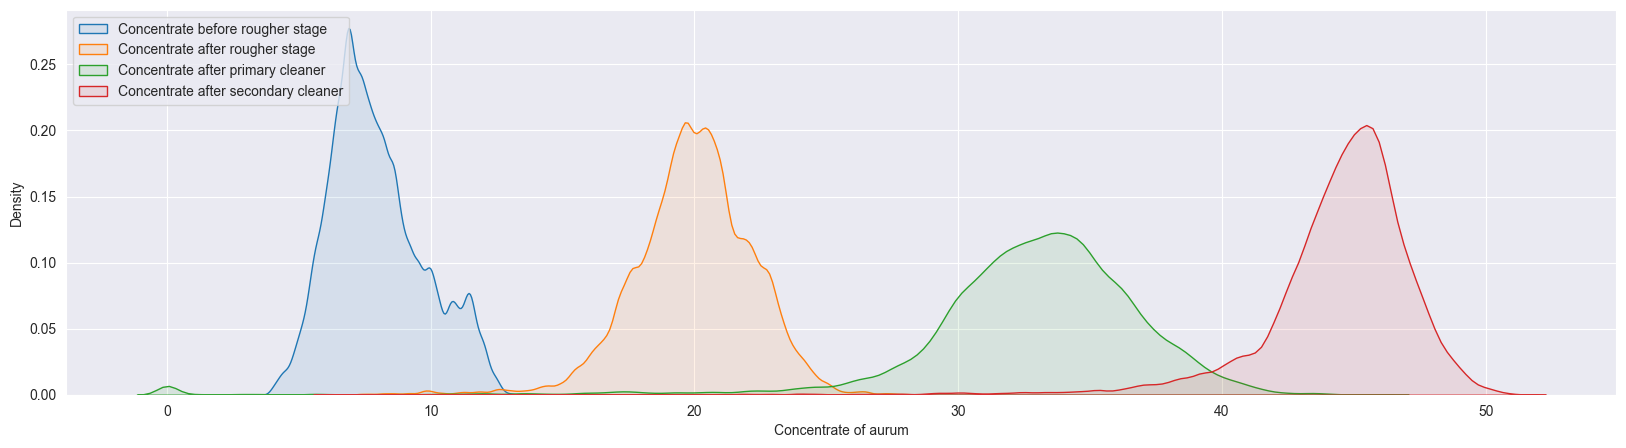

In [30]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train, x='rougher_input_feed_au', shade=True, alpha=0.1, label='Concentrate before rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='rougher_output_concentrate_au', shade=True, alpha=0.1,
            label='Concentrate after rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='primary_cleaner_output_concentrate_au', shade=True, alpha=0.1,
            label='Concentrate after primary cleaner', bw_adjust=0.5)
sns.kdeplot(data=df_train, x='final_output_concentrate_au', shade=True, alpha=0.1,
            label='Concentrate after secondary cleaner', bw_adjust=0.5)
plt.xlabel('Concentrate of aurum')
plt.legend(loc='upper left')
plt.show()
# df_train['rougher_output_concentrate_au'].
# sns.histplot()

На графике мы видим, как от этапа к этапу значение концентрации золота увеличивается.

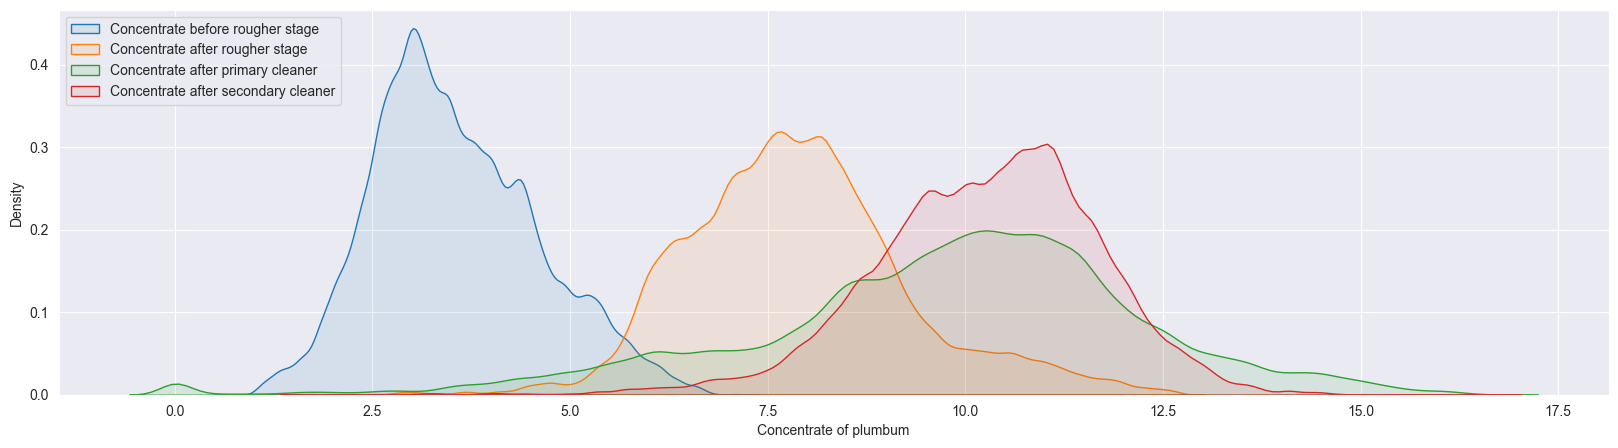

In [31]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train, x='rougher_input_feed_pb', shade=True, alpha=0.1, label='Concentrate before rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='rougher_output_concentrate_pb', shade=True, alpha=0.1,
            label='Concentrate after rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='primary_cleaner_output_concentrate_pb', shade=True, alpha=0.1,
            label='Concentrate after primary cleaner', bw_adjust=0.5)
sns.kdeplot(data=df_train, x='final_output_concentrate_pb', shade=True, alpha=0.1,
            label='Concentrate after secondary cleaner', bw_adjust=0.5)
plt.xlabel('Concentrate of plumbum')
plt.legend(loc='upper left')
plt.show()
# df_train['rougher_output_concentrate_au'].
# sns.histplot()

Концентрация свинца увеличивается после процесса флотации, однако два последующих этапа очистки уже столь значительно не влияют на концентрацию свинца в концентрате.

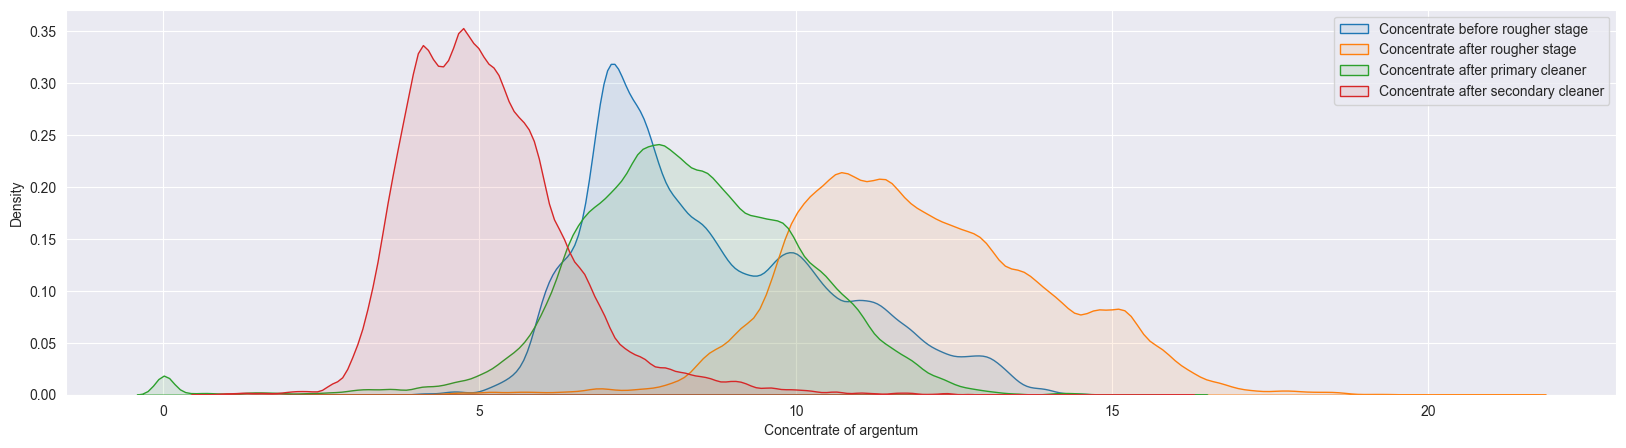

In [32]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train, x='rougher_input_feed_ag', shade=True, alpha=0.1, label='Concentrate before rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='rougher_output_concentrate_ag', shade=True, alpha=0.1,
            label='Concentrate after rougher stage',
            bw_adjust=0.5)
sns.kdeplot(data=df_train, x='primary_cleaner_output_concentrate_ag', shade=True, alpha=0.1,
            label='Concentrate after primary cleaner', bw_adjust=0.5)
sns.kdeplot(data=df_train, x='final_output_concentrate_ag', shade=True, alpha=0.1,
            label='Concentrate after secondary cleaner', bw_adjust=0.5)
plt.xlabel('Concentrate of argentum')
plt.legend()
plt.show()

Концентрация железа повышается после процесса флотации, однако снижается от этапа к этапу и достигает минимума на последнем этапе очистки.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

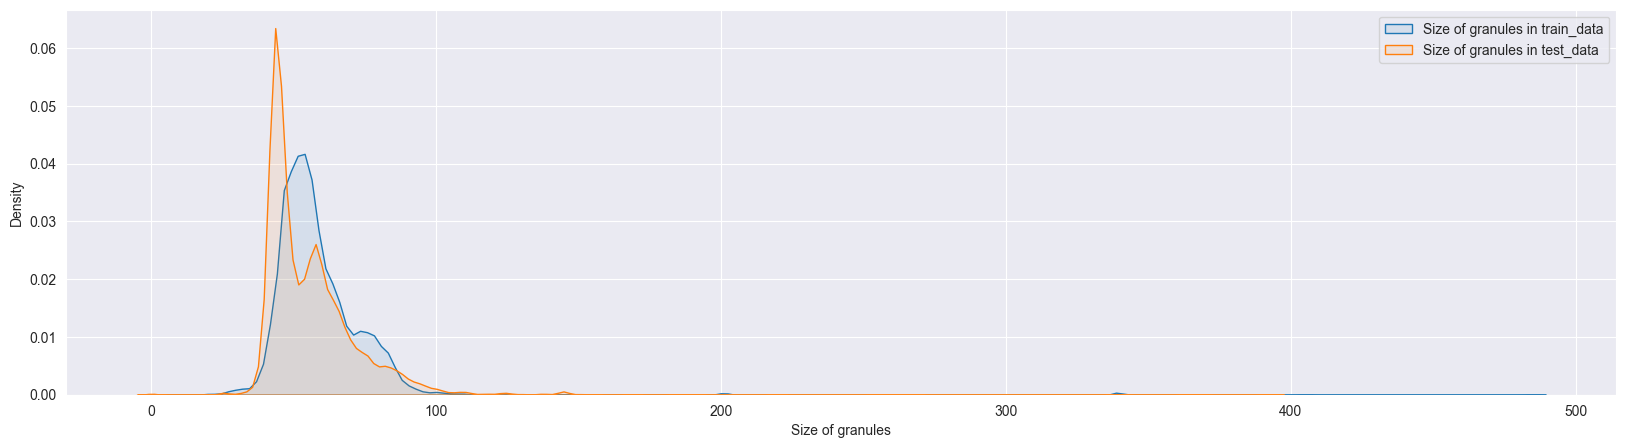

In [33]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train, x='rougher_input_feed_size', shade=True, alpha=0.1, label='Size of granules in train_data',
            bw_adjust=0.5)
sns.kdeplot(data=df_test, x='rougher_input_feed_size', shade=True, alpha=0.1,
            label='Size of granules in test_data', bw_adjust=0.5)
plt.xlabel('Size of granules')
plt.legend()
plt.show()

Распределение тестовых данных большей частью будет объясняться через тренировочную выборку. Однако заметно, что в тестовой выборке преобладают более мелкие гранулы, в тренировочном df же гранулы обладают большим размером. В целом, это говорит нам о том, что, вероятно, предсказания будут смещены в большую сторону.

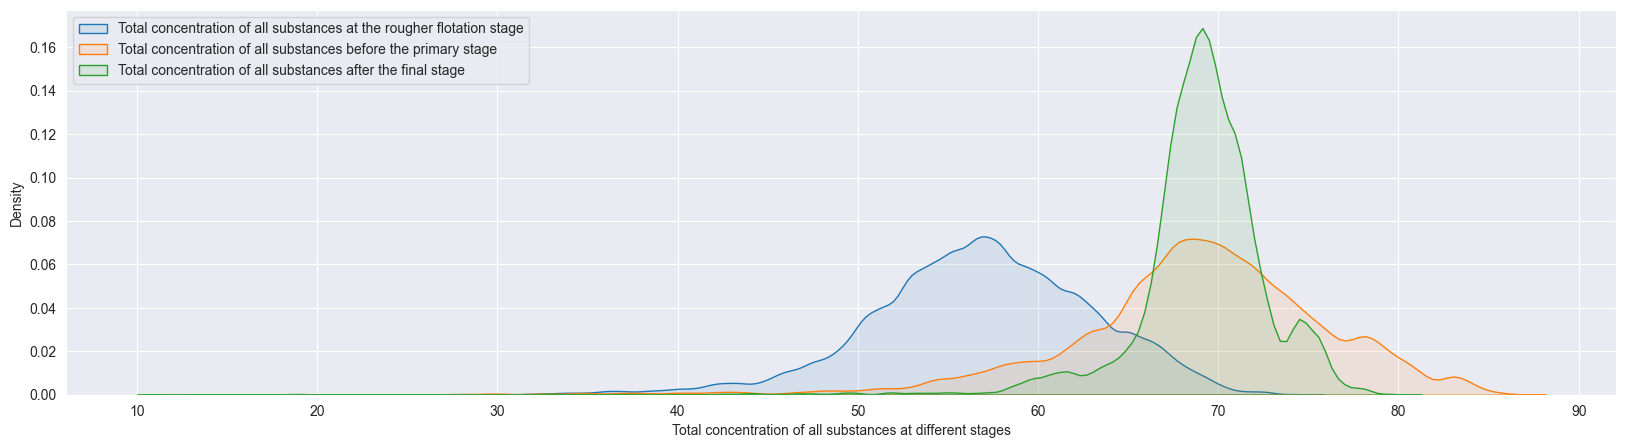

In [34]:
plt.figure(figsize=(20, 5))
sns.kdeplot(data=df_train, x=df_train[
    ['rougher_input_feed_sol', 'rougher_input_feed_pb', 'rougher_input_feed_au', 'rougher_input_feed_ag']].sum(axis=1),
            shade=True,
            alpha=0.1, label='Total concentration of all substances at the rougher flotation stage', bw_adjust=0.5)
sns.kdeplot(data=df_train, x=df_train[
    ['rougher_output_concentrate_ag', 'rougher_output_concentrate_au', 'rougher_output_concentrate_pb',
     'rougher_output_concentrate_sol']].sum(axis=1), shade=True,
            alpha=0.1, label='Total concentration of all substances before the primary stage', bw_adjust=0.5)
sns.kdeplot(data=df_train, x=df_train[
    ['final_output_concentrate_au', 'final_output_concentrate_ag', 'final_output_concentrate_pb',
     'final_output_concentrate_sol']].sum(axis=1), shade=True,
            alpha=0.1, label='Total concentration of all substances after the final stage', bw_adjust=0.5)
plt.xlabel('Total concentration of all substances at different stages')
plt.legend(loc='upper left')
plt.show()

Видим увеличение суммарной концентрации всех веществ после процесса флотации. В дальнейшем суммарная концентрация значительно не меняется. В черновом концентрате и в финальном концентрате медианное значение приблизительно совпадает, но данные распределения имеют различную величину стандартного отклонения.

## Модель

In [35]:
df_train = df_train.drop(
    columns=['rougher_output_concentrate_pb', 'rougher_output_concentrate_ag', 'rougher_output_concentrate_sol',
             'primary_cleaner_output_concentrate_au', 'primary_cleaner_output_concentrate_ag',
             'primary_cleaner_output_concentrate_pb', 'primary_cleaner_output_concentrate_sol',
             'final_output_concentrate_ag', 'final_output_concentrate_pb', 'final_output_concentrate_sol'])

In [36]:
train_features = df_train.drop(columns=['rougher_output_concentrate_au', 'final_output_concentrate_au'])
train_target_r = df_train['rougher_output_concentrate_au']
train_target_f = df_train['final_output_concentrate_au']

test_features = df_test.drop(columns=['rougher_output_concentrate_au', 'final_output_concentrate_au'])
test_features = test_features[train_features.columns]
test_target_r = df_test['rougher_output_concentrate_au']
test_target_f = df_test['final_output_concentrate_au']

In [37]:
test_features

,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_sulfate,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,primary_cleaner_state_floatbank8_d_air,primary_cleaner_state_floatbank8_d_level,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,14.993117,8.080000,210.800903,1.005021,1398.981323,-500.225586,-499.919739,1400.103027,1399.001709,-499.485138,...,12.023554,-497.795837,8.016657,-501.289154,7.946562,-432.317841,4.872511,-500.037445,26.705889,-499.709412
2016-09-01 01:59:59,14.987472,8.080000,215.392456,0.990469,1398.777954,-500.057434,-499.778168,1396.151001,1399.508057,-500.416321,...,12.058140,-498.695770,8.130980,-499.634216,7.958270,-525.839661,4.878850,-500.162384,25.019939,-499.819427
2016-09-01 02:59:59,12.884933,7.786667,215.259949,0.996043,1398.493652,-500.868347,-499.764526,1398.075684,1399.497070,-499.715485,...,11.962366,-498.767487,8.096892,-500.827423,8.071055,-500.801666,4.905125,-499.828522,24.994862,-500.622559
2016-09-01 03:59:59,12.006805,7.640000,215.336243,0.863514,1399.618164,-498.863586,-499.211029,1400.129272,1401.065186,-501.038727,...,12.033091,-498.350922,8.074945,-499.474396,7.897085,-500.868500,4.931399,-499.963623,24.948919,-498.709991
2016-09-01 04:59:59,10.682530,7.530000,199.099319,0.805575,1401.268066,-500.808319,-499.504547,1402.172241,1399.480469,-499.374054,...,12.025367,-500.786499,8.054678,-500.397491,8.107890,-509.526733,4.957675,-500.360016,25.003332,-500.856323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:59:59,15.963399,8.070000,173.957764,0.896701,1401.930542,-499.728851,-499.193420,1399.810303,1400.334839,-499.243469,...,13.995957,-500.157440,12.069155,-499.673279,7.977259,-499.516113,5.933319,-499.965973,8.987170,-499.755920
2017-12-31 20:59:59,16.002605,8.070000,172.910263,0.896519,1447.075684,-494.716827,-465.963013,1443.890381,1447.653442,-480.403839,...,16.749781,-496.031525,13.365372,-499.122711,9.288553,-496.892975,7.372898,-499.942963,8.986833,-499.903748
2017-12-31 21:59:59,15.993670,8.070000,171.135712,1.165996,1498.836182,-501.770416,-495.516357,1502.749268,1502.585327,-498.260223,...,19.994131,-499.791321,15.101424,-499.936249,10.989181,-498.347900,9.020945,-500.040436,8.982038,-497.789886


In [38]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    absolute_diff = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape = np.mean(absolute_diff / denominator) * 100
    return smape

In [39]:
def smape_total(smape_rougher, smape_finally):
    return 0.25 * smape_rougher + 0.75 * smape_finally

In [40]:
models = [
    {
        'name': 'Linear_regression',
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
        }
    },
    {
        'name': 'Lasso',
        'model': Lasso(),
        'params': {
            'alpha': list(np.arange(0.01, 1, 0.01)),
            'selection': ['cyclic', 'random'],
            'random_state': [42]
        }
    },
    {
        'name': 'Ridge',
        'model': Ridge(),
        'params': {
            'alpha': list(np.arange(0.01, 500, 0.01)),
            'random_state': [42]
        }
    },
    # {
    #     'name': 'Decision_tree_regressor',
    #     'model': DecisionTreeRegressor(),
    #     'params': {
    #         'criterion': ['absolute_error', 'squared_error'],
    #         'max_depth': list(range(4, 48)),
    #         'min_samples_split': list(range(2, 10)),
    #         'min_samples_leaf': list(range(1, 10)),
    #         'random_state': [42]
    #     }
    # },
    # {
    #     'name': 'Random_forest_regressor',
    #     'model': RandomForestRegressor(),
    #     'params': {
    #         'n_estimators': [50, 100, 200],
    #         'max_depth': list(range(4, 48)),
    #         'min_samples_split': list(range(2, 10)),
    #         'min_samples_leaf': list(range(1, 10)),
    #         'random_state': [42]
    #     }
    # }
]

best_rougher_score = 999
best_rougher_params = None
for model in models:
    pipeline = make_pipeline(RobustScaler(),
                             RandomizedSearchCV(model['model'], param_distributions=model['params'], random_state=42,
                                                cv=5, n_jobs=-1,
                                                scoring=make_scorer(symmetric_mean_absolute_percentage_error,
                                                                    greater_is_better=False)))
    pipeline.fit(train_features, train_target_r)
    random_search_cv = pipeline.named_steps['randomizedsearchcv']
    best_params = random_search_cv.best_params_
    best_score = -random_search_cv.best_score_
    print(f'Лучшие параметры стадии флотации для {model["name"]}: {best_params}, метрика sMAPE={best_score:.3f}')
    if best_rougher_score > best_score:
        best_rougher_score = best_score
        best_rougher_params = best_params

best_finally_score = 999
best_finally_params = None
for model in models:
    pipeline = make_pipeline(RobustScaler(),
                             RandomizedSearchCV(model['model'], param_distributions=model['params'], random_state=42,
                                                cv=5, n_jobs=-1,
                                                scoring=make_scorer(symmetric_mean_absolute_percentage_error,
                                                                    greater_is_better=False)))
    pipeline.fit(train_features, train_target_f)
    random_search_cv = pipeline.named_steps['randomizedsearchcv']
    best_params = random_search_cv.best_params_
    best_score = -random_search_cv.best_score_
    print(f'Лучшие параметры финальной стадии для {model["name"]}: {best_params}, метрика sMAPE={best_score:.3f}')
    if best_finally_score > best_score:
        best_finally_score = best_score
        best_finally_params = best_params

print(f'Итоговое значение sMAPE на тренировочной выборке: {smape_total(best_rougher_score, best_finally_score):.3f}')

C:\Users\Sellch\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры стадии флотации для Linear_regression: {'fit_intercept': True}, метрика sMAPE=8.540
Лучшие параметры стадии флотации для Lasso: {'selection': 'cyclic', 'random_state': 42, 'alpha': 0.09}, метрика sMAPE=7.899
Лучшие параметры стадии флотации для Ridge: {'random_state': 42, 'alpha': 447.33}, метрика sMAPE=7.486
Лучшие параметры финальной стадии для Linear_regression: {'fit_intercept': True}, метрика sMAPE=5.530


C:\Users\Sellch\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры финальной стадии для Lasso: {'selection': 'cyclic', 'random_state': 42, 'alpha': 0.09}, метрика sMAPE=5.017
Лучшие параметры финальной стадии для Ridge: {'random_state': 42, 'alpha': 471.92}, метрика sMAPE=5.074
Итоговое значение sMAPE на тренировочной выборке: 5.634


In [41]:
pipeline = make_pipeline(RobustScaler(), Ridge(**best_rougher_params))
model_r = pipeline.fit(train_features, train_target_r)
predict_r = model_r.predict(test_features)

pipeline = make_pipeline(RobustScaler(), Lasso(**best_finally_params))
model_f = pipeline.fit(train_features, train_target_f)
predict_f = model_f.predict(test_features)

print(f"""Итоговое значение sMAPE:
{smape_total(symmetric_mean_absolute_percentage_error(test_target_r, predict_r),
             symmetric_mean_absolute_percentage_error(test_target_f, predict_f)):.3f}""")

Итоговое значение sMAPE:
8.077


---
### *Проверка модели на адекватность*

Создадим dummy модель, которая предскажет все целые значения средним значением и выведем результат нашей целевой метрики.
Далее сравним это значение с получившимся значением на тестовой выборке.

In [42]:
print(f"""{smape_total(
    symmetric_mean_absolute_percentage_error(test_target_r, np.array([test_target_r.mean()] * len(test_target_r))),
    symmetric_mean_absolute_percentage_error(test_target_f, np.array([test_target_f.mean()] * len(test_target_f))))
:.3f}""")

8.423


Модель успешно прошла проверку на адекватность.

---
## Общий вывод по исследованию

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Данные проверены на отсутствие дубликатов.
- Произведена оптимизация формата размерности количественных данных.
- Проведено устранение мультиколлинеарности независимых признаков.
- С помощью двух функций обнаружены и устранены выбросы.
- Данные подготовлены к дальнейшему использованию при построении модели.
- Построен pipeline для подбора гиперпараметров на тренировочной выборке с использованием кросс-валидации. Для более тонкого и точного выбора модели под конкретный целевой признак были использованы два pipeline с поиском через RandomizedSearchCV.
- Лучшее значение метрики smape с результатом 7.543 при прогнозировании целевого признака `rougher_output_concentrate_au` показала модель Ridge регрессии.
- Лучшее значение метрики smape с результатом 5.039 при прогнозировании целевого признака `final_output_concentrate_au` показала модель Lasso регрессии.
- Получившееся итоговое значение sMAPE на тренировочной выборке: 5.665.
- На найденных наилучших моделях с использованием наилучших параметров для этих моделей было произвдено обучение на всем размере тренировочного датафрейма и предсказаны значения по тестовой выборке. Итоговое значение sMAPE на тестовой выборке: 8.082.
- Произведена проверка модели на адекватность. При использовании заполнения dummy модели средними значениями целевых признаков получено значение общей целевой метрики sMAPE: 8.423. Из этого следует что, модель успешно прошла проверку на адекватность.